# Poyntingflux.ipynb

質量密度の値からAlfven conductance

$\Sigma_A = \sqrt{\frac{\rho}{\mu_0 B^2}}$

を計算し、

$\bar{\alpha} = 1-\frac{2 \Sigma_A}{\Sigma_P + 2\Sigma_A}$

を用いてPoynting flux

$S = 2\pi R_{eff}^2 (\bar{\alpha}u_0)^2 B \sqrt{\frac{\rho}{\mu_0}}$

を導出する。

Pedersen conductanceは以下の近似式

$\Sigma_P = \left(\frac{n}{n_c}\right)^\kappa \Sigma_{P0}$

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF',
        '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF',
          '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold',
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [2]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [3]:
# %% 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
RE = 1.56E+6             # MOON RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
r_orbit = 9.38*RJ        # ORBITAL RADIUS (average) [m] (Bagenal+2015)
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
OMGR = 2*np.pi/(Psyn_eu)    # Moon's synodic angular velocity [rad/sec]
u = 100E+3              # 共回転速度 [m s-1]
a_bar = 0.8             # 1-プラズマフローの減速率 (Saur+1998)
R_eff = 4.2*RE/2        # フラックスチューブの半径
Ai = 18                 # イオン原子量 [amu]

In [4]:
# 等高線のふち (amu cm-3 & eV)
"""
14 ===
Rho
[1303.60557713  920.52383102  788.63221675 1206.60730149  852.02978201
 1408.40147298 1581.60074835 1206.60730149  788.63221675 1581.60074835
 1116.82644318 1160.84923261]
Ti
[ 71.54245234 130.84708648 139.92567679  93.56151816 122.3575289
  81.81454916  62.56005246 100.05311621 149.63416879  66.90066944
  87.49110484 106.99512214]
22 ===
Rho
[1581.60074835 1643.94389677 1581.60074835 1994.51654932 1846.10918638
 1521.621834   1463.91749505 1846.10918638 1354.99078042 1463.91749505
 1846.10918638 1846.10918638]
Ti
[195.68800819 182.99147318 223.78497859 149.63416879 182.99147318
 209.26546949 273.67240544 195.68800819 273.67240544 255.91612437
 160.01626708 160.01626708]
"""

rho14_arr = np.array([1303.60557713, 920.52383102, 788.63221675, 1206.60730149, 852.02978201,
                      1408.40147298, 1581.60074835, 1206.60730149, 788.63221675, 1581.60074835, 1116.82644318, 1160.84923261])
Ti14_arr = np.array([71.54245234, 130.84708648, 139.92567679, 93.56151816, 122.3575289,
                     81.81454916, 62.56005246, 100.05311621, 149.63416879, 66.90066944,
                     87.49110484, 106.99512214])

rho22_arr = np.array([1581.60074835, 1643.94389677, 1581.60074835, 1994.51654932, 1846.10918638,
                      1521.621834, 1463.91749505, 1846.10918638, 1354.99078042, 1463.91749505,
                      1846.10918638, 1846.10918638])
Ti22_arr = np.array([195.68800819, 182.99147318, 223.78497859, 149.63416879, 182.99147318,
                     209.26546949, 273.67240544, 195.68800819, 273.67240544, 255.91612437,
                     160.01626708, 160.01626708])

In [5]:
def Calc1(S3wlon):
    S3lat = np.zeros(S3wlon.shape)                    # [rad]
    theta_arr = 0.5*np.pi-S3lat
    phi_arr = 2*np.pi-S3wlon

    B = np.zeros(S3wlon.shape)
    Br = np.zeros(S3wlon.shape)
    Btheta = np.zeros(S3wlon.shape)
    Bphi = np.zeros(S3wlon.shape)

    x_arr = r_orbit*np.sin(theta_arr)*np.cos(phi_arr)
    y_arr = r_orbit*np.sin(theta_arr)*np.sin(phi_arr)
    z_arr = r_orbit*np.cos(theta_arr)

    for i in range(S3wlon.size):
        theta = theta_arr[i]
        phi = phi_arr[i]
        x = x_arr[i]
        y = y_arr[i]
        z = z_arr[i]

        Bv = BJRM.B().JRM33(r_orbit, theta, phi)*1E-9        # [T]
        Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
            + Bv[1]*math.cos(theta)*math.cos(phi) \
            - Bv[2]*math.sin(phi)
        By = Bv[0]*math.sin(theta)*math.sin(phi) \
            + Bv[1]*math.cos(theta)*math.sin(phi) \
            + Bv[2]*math.cos(phi)
        Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

        Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
        Bx += Bcs[0]
        By += Bcs[1]
        Bz += Bcs[2]

        B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]
        Br[i] = Bx*math.sin(theta)*math.cos(phi) \
            + By*math.sin(theta)*math.sin(phi) \
            + Bz*math.cos(theta)
        Btheta[i] = Bx*math.cos(theta)*math.cos(phi) \
            + By*math.cos(theta)*math.sin(phi) \
            - Bz*math.sin(theta)
        Bphi[i] = -Bx*math.sin(phi) + By*math.cos(phi)

        B[i] = B0


    # ダイポール座標系に持っていく
    # S3RH で Z3軸 の(右ネジ)まわりに-155.8度回転
    phiRH0 = math.radians(-155.8)    # Connerney+2020
    rvec1 = np.array([
        x_arr*math.cos(phiRH0) - y_arr*math.sin(phiRH0),
        x_arr*math.sin(phiRH0) + y_arr*math.cos(phiRH0),
        z_arr
    ])

    # S3RH で Y3軸 の(右ネジ)まわりに-9.3度回転
    THETA_D = math.radians(-6.7)
    rvec1 = np.array([
        rvec1[0]*math.cos(THETA_D) + rvec1[2]*math.sin(THETA_D),
        rvec1[1],
        -rvec1[0]*math.sin(THETA_D) + rvec1[2]*math.cos(THETA_D)
    ])
    
    return B, rvec1

In [6]:
# 質量密度
def RHO_H(rho, Ti, rvec1):
    """
    Args:
        rho [amu cm-3]
        Ti [eV]

    Returns:
        rho1 [kg m-3], H [m]
    """
    rho *= AMU*1E+6         # プラズマシート質量密度 [kg m-3]
    H0 = 0.64*RJ
    H = H0*np.sqrt(Ti/Ai)
    rho1 = rho*np.exp(-(rvec1[2]/H)**2)
    
    return rho1, H

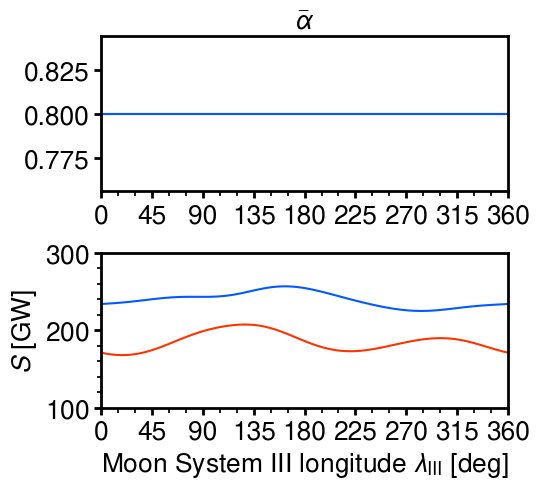

In [7]:
fontsize = 19
fig, ax = plt.subplots(2,1,figsize=(5.5,5),dpi=100)
for i in range(2):
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].set_xlim(0, 360)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[0].set_title(r'$\bar{\alpha}$', fontsize=fontsize)
# ax[1].set_title(r'Poynting flux $S$ [GW]', fontsize=fontsize)
ax[1].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax[1].yaxis.get_offset_text().set_fontsize(fontsize)
ax[1].set_xlabel('Moon System III longitude $\\lambda_{\\rm III}$ [deg]', fontsize=fontsize)
ax[1].set_ylim(100,300)
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[1].set_ylabel(r'$S$ [GW]', fontsize=fontsize)


# JAN 2014
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1207, Ti=87, rvec1=rvec1)

Sig_P0 = 30      # Pedersen conductance [S] (Saur+2013)
kappa = 1        # Saur+2013
Sig_P = ((rho1/(1207*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
alpha_bar = 0.8*np.ones(S3wlon.shape)
S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[0])
ax[1].plot(np.degrees(S3wlon), S*1E-9, color=cud4[0], zorder=1)
S_const_2014 = S

pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = 0.8*np.ones(S3wlon.shape)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_14_arr[i, :] = S
"""ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)"""


# OCT 2022
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1708, Ti=195, rvec1=rvec1)

Sig_P0 = 30      # Pedersen conductance [S] (Saur+2013)
kappa = 1        # Saur+2013
Sig_P = ((rho1/(1708*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
alpha_bar = 0.8*np.ones(S3wlon.shape)
S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
S_const_2022 = S

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[3])
ax[1].plot(np.degrees(S3wlon), S*1E-9, color=cud4[3], zorder=1)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = 0.8*np.ones(S3wlon.shape)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_22_arr[i, :] = S
"""ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)"""

fig.tight_layout()
plt.show()

%:  0.9545173775958029


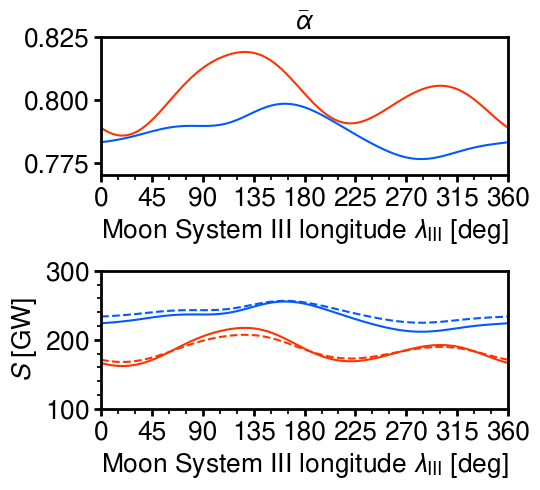

In [8]:
fontsize = 19
fig, ax = plt.subplots(2,1,figsize=(5.5,5),dpi=100)
for i in range(2):
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].set_xlim(0, 360)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[0].set_title(r'$\bar{\alpha}$', fontsize=fontsize)
ax[0].set_xlabel('Moon System III longitude $\\lambda_{\\rm III}$ [deg]', fontsize=fontsize)
# ax[1].set_title(r'Poynting flux $S$ [W]', fontsize=fontsize)
ax[1].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax[1].yaxis.get_offset_text().set_fontsize(fontsize)
ax[1].set_xlabel('Moon System III longitude $\\lambda_{\\rm III}$ [deg]', fontsize=fontsize)
ax[0].set_ylim(0.770, 0.825)
ax[1].set_ylim(100,300)
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[1].set_ylabel(r'$S$ [GW]', fontsize=fontsize)


# JAN 2014
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1207, Ti=87, rvec1=rvec1)

Sig_P0 = 30      # Pedersen conductance [S] (Saur+2013)
kappa = 1        # Saur+2013
Sig_P = ((rho1/(1207*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
alpha_bar = Sig_P/(Sig_P+2*Sig_A)
S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[0])
ax[1].plot(np.degrees(S3wlon), S*1E-9, color=cud4[0], zorder=1)
ax[1].plot(np.degrees(S3wlon), S_const_2014*1E-9, color=cud4[0], linestyle='dashed', zorder=1)
idx135 = np.argmin(np.abs(np.degrees(S3wlon)-135))
print('%: ', S_const_2014[idx135]/S[idx135])


pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = Sig_P/(Sig_P+2*Sig_A)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_14_arr[i, :] = S
"""ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)"""


# OCT 2022
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1708, Ti=195, rvec1=rvec1)

Sig_P0 = 30      # Pedersen conductance [S] (Saur+2013)
kappa = 1        # Saur+2013
Sig_P = ((rho1/(1708*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
alpha_bar = Sig_P/(Sig_P+2*Sig_A)
S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[3])
ax[1].plot(np.degrees(S3wlon), S*1E-9, color=cud4[3], zorder=1)
ax[1].plot(np.degrees(S3wlon), S_const_2022*1E-9, color=cud4[3], linestyle='dashed', zorder=1)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = Sig_P/(Sig_P+2*Sig_A)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_22_arr[i, :] = S
"""ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)"""

fig.tight_layout()
plt.show()

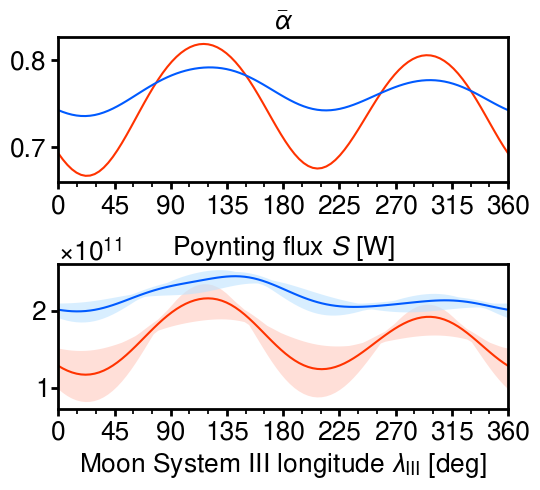

In [9]:
fontsize = 19
fig, ax = plt.subplots(2,1,figsize=(5.5,5),dpi=100)
for i in range(2):
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].set_xlim(0, 360)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[0].set_title(r'$\bar{\alpha}$', fontsize=fontsize)
ax[1].set_title(r'Poynting flux $S$ [W]', fontsize=fontsize)
ax[1].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax[1].yaxis.get_offset_text().set_fontsize(fontsize)
ax[1].set_xlabel('Moon System III longitude $\\lambda_{\\rm III}$ [deg]', fontsize=fontsize)


# JAN 2014
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1207, Ti=87, rvec1=rvec1)

Sig_P0 = 30      # Pedersen conductance [S] (Saur+2013)
kappa = 2        # Saur+2013
Sig_P = ((rho1/(1207*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]

alpha_bar = Sig_P/(Sig_P+2*Sig_A)

S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[0])
ax[1].plot(np.degrees(S3wlon), S, color=cud4[0], zorder=1)

pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = Sig_P/(Sig_P+2*Sig_A)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_14_arr[i, :] = S
ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)


# OCT 2022
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1708, Ti=195, rvec1=rvec1)

Sig_P0 = 30      # Pedersen conductance [S] (Saur+2013)
kappa = 2        # Saur+2013
Sig_P = ((rho1/(1708*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
alpha_bar = Sig_P/(Sig_P+2*Sig_A)
S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[3])
ax[1].plot(np.degrees(S3wlon), S, color=cud4[3], zorder=1)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = Sig_P/(Sig_P+2*Sig_A)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_22_arr[i, :] = S
ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)

fig.tight_layout()
plt.show()

# Compared to brightness

In [10]:
# Data load (Brightness)
def load(csvname0):
    df = pd.read_csv(csvname0, sep='\t')
    utc = df.loc[:, 'date']                                 # UTC date
    # EFP latitude [deg]
    efplat = df.loc[:, 'lat [deg]'].values
    # EFP System III longitude [deg]
    efpwlong = df.loc[:, 'wlong [deg]'].values
    # Europa's System III longitude [deg]
    moons3 = df.loc[:, 'Moon S3 [deg]'].values
    # EFP brightness [kR]
    final_phot_ave = df.loc[:, 'spot brightness [kR]']
    # local background [kR]
    annulus_median = df.loc[:, 'local background [kR]']

    b0_arr = np.zeros(len(final_phot_ave))
    b1_arr = np.zeros(len(final_phot_ave))
    efplat0_arr = np.zeros(len(final_phot_ave))
    efpwlong0_arr = np.zeros(len(final_phot_ave))
    moons30_arr = np.zeros(len(final_phot_ave))
    for i in range(len(final_phot_ave)):
        if final_phot_ave[i] != '0':
            b0_arr[i] = final_phot_ave[i]
            b1_arr[i] = annulus_median[i]
            efplat0_arr[i] = efplat[i]
            efpwlong0_arr[i] = efpwlong[i]
            moons30_arr[i] = moons3[i]
        else:
            continue

    return utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr

In [11]:
def EP_CALC2(B_kR):
    # Assumed: 10 kR = 1 mW m-2 electron energy flux (Gustin+2012)
    # Assumed: radius of EFP = 300 km on Jupiter (Moirano+2021)

    # Count rate
    Ct_convert = 1/4523     # Gustin+2012 CR=2.5
    Ct = Ct_convert*B_kR
    Ct2Flux = 400*1E-3      # W m-2 (count s-1)-1

    Rf = 300*1E+3   # radius of EFP [m]
    EP_E = B_kR*(4391/4523) * 0.1 * np.pi * (Rf**2) * 1E-3      # [W]
    EP_E = Ct*Ct2Flux*np.pi*(Rf**2)      # [W]

    return EP_E

In [12]:
# Brightness data
north_doy = ['14/006_v06', '14/013_v13',
             '14/016_v12', '22/271_v18', '22/274_v17']
doy = north_doy
doyname = ['2014-01-06', '2014-01-13', '2014-01-16'] + \
    ['2022-09-28', '2022-10-01']
colorratio = [2.0, 2.0, 2.0, 2.0, 2.0]
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N2 = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
cud4_N3 = [cud4[0], cud4[3]]

# Brightness
moon_leadback_ave = np.zeros(len(doy))
EP_70180 = np.zeros(len(doy))
moon_leadback_std = np.zeros(len(doy))
EP_std = np.zeros(len(doy))

for i in range(len(doy)):
    # print(doyname[i])
    csvname0 = 'data/Brightness/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr > 0)
    utc = utc[idx[0]]
    b0_arr = b0_arr[idx]       # [kR]
    b1_arr = b1_arr[idx]       # [kR]
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]

    # リード角補正
    lead_data = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    eq_leadangle = lead_data[1, :]   # lead angle [deg]
    if doy[i] == '22/271_v18':
        # なぜかリード角のデータと1行目が合わない
        utc = utc[1:]
        efplat0_arr = efplat0_arr[1:]
        efpwlong0_arr = efpwlong0_arr[1:]
        moons30_arr = moons30_arr[1:]
        b0_arr = b0_arr[1:]
        b1_arr = b1_arr[1:]
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    moon_leadback = moons30_arr-eq_leadangle
    moon_leadback_ave[i] = np.average(moon_leadback)
    moon_leadback_std[i] = np.std(moon_leadback)

    EP = EP_CALC2(B_kR=b0_arr)
    EP_70180[i] = np.average(EP)
    EP_std[i] = np.std(EP)           # Standard deviation [W]
    print('W-long. [deg]: ', moon_leadback_ave)
    print('Emission [GW]: ', EP_70180[i]*1E-9)
    print('---')

W-long. [deg]:  [133.42524958   0.           0.           0.           0.        ]
Emission [GW]:  3.7180103068089814
---
W-long. [deg]:  [133.42524958  98.28193689   0.           0.           0.        ]
Emission [GW]:  2.9876913212044665
---
W-long. [deg]:  [133.42524958  98.28193689 187.72694177   0.           0.        ]
Emission [GW]:  2.130564971986167
---
W-long. [deg]:  [133.42524958  98.28193689 187.72694177  83.8210169    0.        ]
Emission [GW]:  2.59200554179549
---
W-long. [deg]:  [133.42524958  98.28193689 187.72694177  83.8210169  168.01983875]
Emission [GW]:  2.6929493370363637
---


# ALPHA CONSTANT 0.8

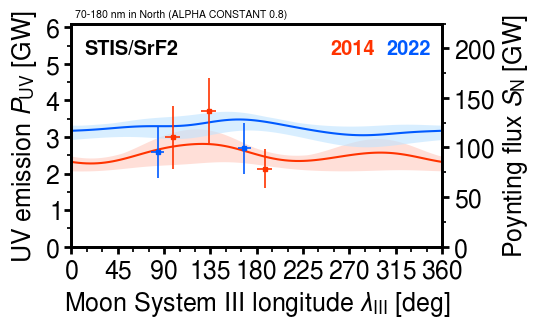

Efficiency:  3.593664506463471 %
Efficiency:  2.9608875148369664 %
Efficiency:  2.3456035395716244 %
Efficiency:  2.133156723561352 %
Efficiency:  2.101368879048547 %


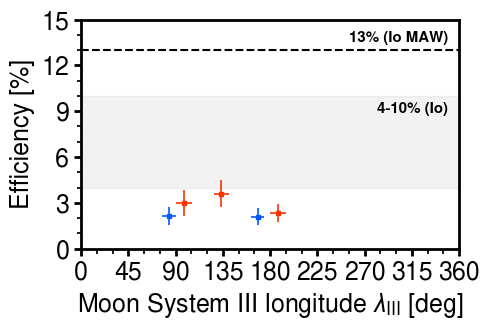

In [76]:
# ALPHA CONSTANT
fontsize = 18
fig, ax = plt.subplots(figsize=(5.5, 3.4), dpi=100)
ax.set_zorder(1)
ax.patch.set_visible(False)  # prevents ax1 from hiding ax2
fig.tight_layout()
# ax.set_title('FUV Power (70-180 nm)', fontsize=fontsize, weight='bold')
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 6.1)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 7, 1))
# ax.set_yticklabels(np.arange(0, 23, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'UV emission $P_{\rm UV}$ [GW]', fontsize=fontsize)
ax.text(0.01, 1.020, r'70-180 nm in North (ALPHA CONSTANT 0.8)',
        color='k',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=fontsize*0.42)
ax.text(0.035, 0.93, 'STIS/SrF2',
        weight='bold',
        color='k',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.70, 0.93, '2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.85, 0.93, '2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)


# Emission
for i in range(len(doy)):
        ax.errorbar(moon_leadback_ave[i], EP_70180[i]*1E-9,
                xerr=moon_leadback_std[i], yerr=EP_std[i]*1E-9,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
    

# POYNTING FLUX
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_ylim(0, 225)
ax2.set_yticks(np.arange(0, 225, 50))
# ax2.set_yticklabels(np.arange(0, 101, 25), fontsize=fontsize)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax2.set_ylabel(r'Poynting flux $S_{\rm N}$ [GW]', fontsize=fontsize)

# POYNTING FLUX IN JAN 2014 and OCT 2022
rho = [1207, 1708]      # [amu cm-3]
Ti = [87, 195]          # [eV]
kappa = 0       # Saur+2013
Sig_P0 = 30     # Pedersen conductance [S] (Kivelson+2004, Saur+2013)
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
for i in range(2):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = 0.8*np.ones(S3wlon.shape)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        ax2.plot(np.degrees(S3wlon), 0.5*S*1E-9, color=cud4_N3[i])

# ERROR SHADES
pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = 0.8*np.ones(S3wlon.shape)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    S *= 0.5*1E-9
    pwr_14_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = 0.8*np.ones(S3wlon.shape)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    S *= 0.5*1E-9
    pwr_22_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)
        
fig.tight_layout()
plt.show()


# EFFICIENCY
S3wlon = np.radians(moon_leadback_ave)      # [rad]
B, rvec1 = Calc1(S3wlon)
rho = [1207, 1207, 1207, 1708, 1708]      # [amu cm-3]
Ti = [87, 87, 87, 195, 195]          # [eV]

fig, ax = plt.subplots(figsize=(5., 3.4), dpi=100)
fig.tight_layout()
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 15)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 16, 3))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'Efficiency [%]', fontsize=fontsize)

for i in range(S3wlon.size):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1[:,i])
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B[i]**2)))  # Alfven conductance [S]
        alpha_bar = 0.8
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B[i]*np.sqrt(rho1/MU0)
        ax.errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S))*100,
                xerr=moon_leadback_std[i], yerr=(EP_std[i]/(0.5*S))*100,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
        print('Efficiency: ', (EP_70180[i]/(0.5*S))*100, '%')

ax.axhline(y=13, linestyle='dashed', color='k')
ax.axhspan(4, 10, color='gray', alpha=0.1)
ax.text(0.97, 0.95, '13% (Io MAW)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)
ax.text(0.97, 0.64, '4-10% (Io)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)
fig.tight_layout()

plt.show()

# KAPPA = 1

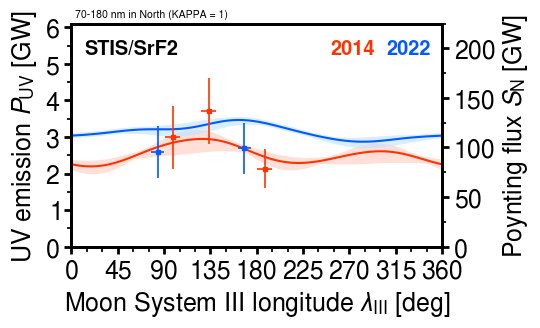

alpha_bar:  0.8189305747161403
Efficiency:  3.429440976570063 %
alpha_bar:  0.8151932413410885
Efficiency:  2.851548364866256 %
alpha_bar:  0.798821832405493
Efficiency:  2.352527616745484 %
alpha_bar:  0.7896382753841906
Efficiency:  2.1895070892464825 %
alpha_bar:  0.7983422491533876
Efficiency:  2.110104888745518 %


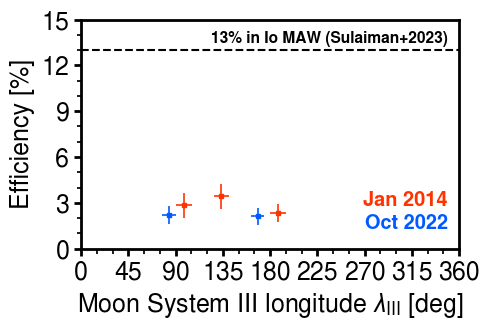

In [77]:
# KAPPA = 1
fontsize = 18
fig, ax = plt.subplots(figsize=(5.5, 3.4), dpi=100)
ax.set_zorder(1)
ax.patch.set_visible(False)  # prevents ax1 from hiding ax2
fig.tight_layout()
# ax.set_title('FUV Power (70-180 nm)', fontsize=fontsize, weight='bold')
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 6.1)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 7, 1))
# ax.set_yticklabels(np.arange(0, 23, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'UV emission $P_{\rm UV}$ [GW]', fontsize=fontsize)
ax.text(0.01, 1.020, r'70-180 nm in North (KAPPA = 1)',
        color='k',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=fontsize*0.42)
ax.text(0.035, 0.93, 'STIS/SrF2',
        weight='bold',
        color='k',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.70, 0.93, '2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.85, 0.93, '2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)


# Emission
for i in range(len(doy)):
        ax.errorbar(moon_leadback_ave[i], EP_70180[i]*1E-9,
                xerr=moon_leadback_std[i], yerr=EP_std[i]*1E-9,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
    

# Poynting flux
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_ylim(0, 225)
ax2.set_yticks(np.arange(0, 225, 50))
# ax2.set_yticklabels(np.arange(0, 101, 25), fontsize=fontsize)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax2.set_ylabel(r'Poynting flux $S_{\rm N}$ [GW]', fontsize=fontsize)


# JAN 2014 and OCT 2022
rho = [1207, 1708]      # [amu cm-3]
Ti = [87, 195]          # [eV]
kappa = 1       # Saur+2013
Sig_P0 = 30     # Pedersen conductance [S] (Kivelson+2004, Saur+2013)
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
for i in range(2):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        ax2.plot(np.degrees(S3wlon), 0.5*S*1E-9, color=cud4_N3[i])

# ERROR SHADES
pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
        rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9
        pwr_14_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
        rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9
        pwr_22_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)

fig.tight_layout()
plt.show()


# EFFICIENCY
S3wlon = np.radians(moon_leadback_ave)      # [rad]
B, rvec1 = Calc1(S3wlon)
rho = [1207, 1207, 1207, 1708, 1708]      # [amu cm-3]
Ti = [87, 87, 87, 195, 195]          # [eV]

fig, ax = plt.subplots(figsize=(5., 3.4), dpi=100)
fig.tight_layout()
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 15)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 16, 3))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'Efficiency [%]', fontsize=fontsize)

S_case1 = np.zeros(S3wlon.size)

for i in range(S3wlon.size):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1[:,i])
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B[i]**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        print('alpha_bar: ', alpha_bar)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B[i]*np.sqrt(rho1/MU0)
        ax.errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S))*100,
                xerr=moon_leadback_std[i], yerr=(EP_std[i]/(0.5*S))*100,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
        print('Efficiency: ', (EP_70180[i]/(0.5*S))*100, '%')
        S_case1[i] = S

ax.axhline(y=13, linestyle='dashed', color='k')
# ax.axhspan(4, 10, color='gray', alpha=0.1)
ax.text(0.97, 0.95, '13% in Io MAW (Sulaiman+2023)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.62)
"""ax.text(0.97, 0.64, '4-10% (Io)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)"""
ax.text(0.97, 0.25, 'Jan 2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.97, 0.15, 'Oct 2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
fig.tight_layout()

plt.show()

# KAPPA = 2

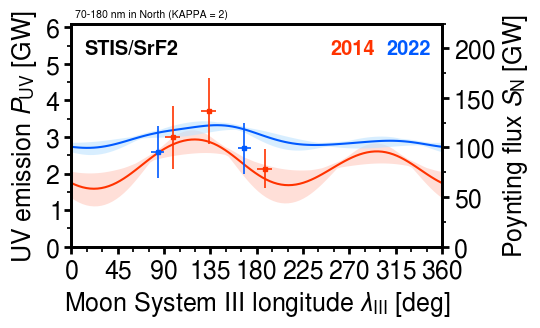

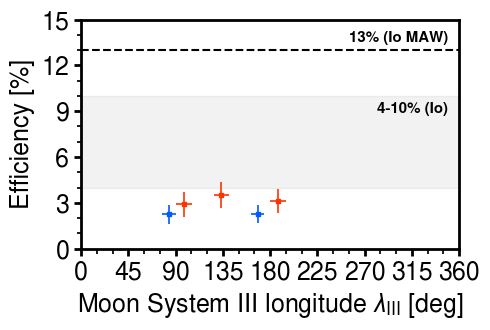

In [78]:
# KAPPA = 2
fontsize = 18
fig, ax = plt.subplots(figsize=(5.5, 3.4), dpi=100)
ax.set_zorder(1)
ax.patch.set_visible(False)  # prevents ax1 from hiding ax2
fig.tight_layout()
# ax.set_title('FUV Power (70-180 nm)', fontsize=fontsize, weight='bold')
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 6.1)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 7, 1))
# ax.set_yticklabels(np.arange(0, 23, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'UV emission $P_{\rm UV}$ [GW]', fontsize=fontsize)
ax.text(0.01, 1.020, r'70-180 nm in North (KAPPA = 2)',
        color='k',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=fontsize*0.42)
ax.text(0.035, 0.93, 'STIS/SrF2',
        weight='bold',
        color='k',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.70, 0.93, '2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.85, 0.93, '2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)


# Emission
for i in range(len(doy)):
        ax.errorbar(moon_leadback_ave[i], EP_70180[i]*1E-9,
                xerr=moon_leadback_std[i], yerr=EP_std[i]*1E-9,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
    

# Poynting flux
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_ylim(0, 225)
ax2.set_yticks(np.arange(0, 225, 50))
# ax2.set_yticklabels(np.arange(0, 101, 25), fontsize=fontsize)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax2.set_ylabel(r'Poynting flux $S_{\rm N}$ [GW]', fontsize=fontsize)


# JAN 2014 and OCT 2022
rho = [1207, 1708]      # [amu cm-3]
Ti = [87, 195]          # [eV]
kappa = 2       # Saur+2013
Sig_P0 = 30     # Pedersen conductance [S] (Kivelson+2004, Saur+2013)

S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)

for i in range(2):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        # alpha_bar = 0.8*np.ones(S3wlon.shape)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        ax2.plot(np.degrees(S3wlon), 0.5*S*1E-9, color=cud4_N3[i])

# ERROR SHADES
pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
        rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9
        pwr_14_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
        rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9
        pwr_22_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)

fig.tight_layout()
plt.show()


# EFFICIENCY
S3wlon = np.radians(moon_leadback_ave)      # [rad]
B, rvec1 = Calc1(S3wlon)
rho = [1207, 1207, 1207, 1708, 1708]      # [amu cm-3]
Ti = [87, 87, 87, 195, 195]          # [eV]

fig, ax = plt.subplots(figsize=(5., 3.4), dpi=100)
fig.tight_layout()
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 15)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 16, 3))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'Efficiency [%]', fontsize=fontsize)

for i in range(S3wlon.size):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1[:,i])
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B[i]**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B[i]*np.sqrt(rho1/MU0)
        ax.errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S))*100,
                xerr=moon_leadback_std[i], yerr=(EP_std[i]/(0.5*S))*100,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)

ax.axhline(y=13, linestyle='dashed', color='k')
ax.axhspan(4, 10, color='gray', alpha=0.1)
ax.text(0.97, 0.95, '13% (Io MAW)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)
ax.text(0.97, 0.64, '4-10% (Io)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)
fig.tight_layout()

plt.show()

# ALPHA = 0.55 (Szalay+2024)

ピークの強さが$\bar{\alpha}=0.55$になるように設定。

$\Sigma_{P0} = 10$ [S] に設定すると、2014年のピークが0.55になる。

In [79]:
kappa = 1       # Saur+2013
Sig_P0 = 10     # Pedersen conductance [S] (Kivelson+2004, Saur+2013)

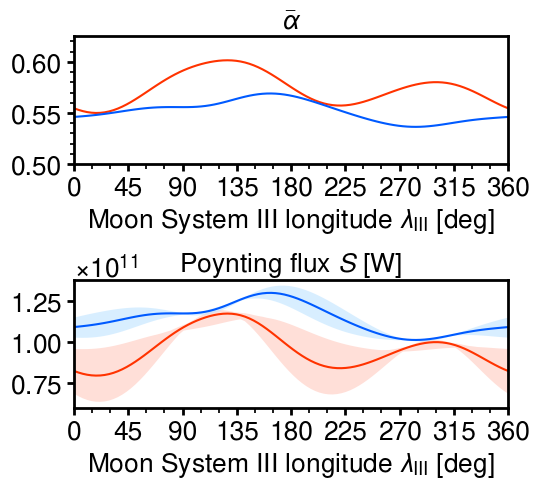

In [80]:
fontsize = 19
fig, ax = plt.subplots(2,1,figsize=(5.5,5),dpi=100)
for i in range(2):
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].tick_params(axis='both', which='both', labelsize=fontsize)
    ax[i].set_xlim(0, 360)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_xlabel('Moon System III longitude $\\lambda_{\\rm III}$ [deg]', fontsize=fontsize)
ax[0].set_title(r'$\bar{\alpha}$', fontsize=fontsize)
ax[1].set_title(r'Poynting flux $S$ [W]', fontsize=fontsize)
ax[1].yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax[1].yaxis.get_offset_text().set_fontsize(fontsize)
ax[0].set_ylim(0.5, 0.625)
ax[0].set_yticks(np.array([0.5, 0.55, 0.6]))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks



# JAN 2014
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1207, Ti=87, rvec1=rvec1)

Sig_P = ((rho1/(1207*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
alpha_bar = Sig_P/(Sig_P+2*Sig_A)
S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[0])
ax[1].plot(np.degrees(S3wlon), S, color=cud4[0], zorder=1)

pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = Sig_P/(Sig_P+2*Sig_A)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_14_arr[i, :] = S
ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)


# OCT 2022
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
rho1, H = RHO_H(rho=1708, Ti=195, rvec1=rvec1)

Sig_P = ((rho1/(1708*AMU*1E+6))**kappa)*Sig_P0
Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
alpha_bar = Sig_P/(Sig_P+2*Sig_A)
S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)

ax[0].plot(np.degrees(S3wlon), alpha_bar, color=cud4[3])
ax[1].plot(np.degrees(S3wlon), S, color=cud4[3], zorder=1)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
    rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
    Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
    Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
    alpha_bar = Sig_P/(Sig_P+2*Sig_A)
    S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
    pwr_22_arr[i, :] = S
ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)

fig.tight_layout()
plt.show()

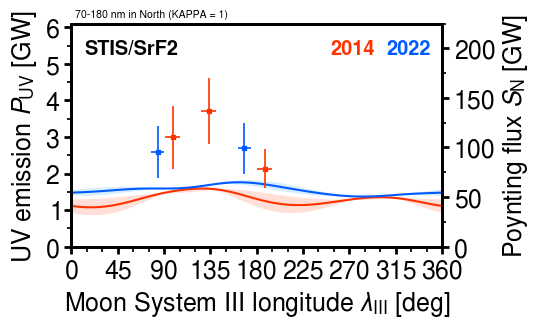

Efficiency:  6.363061086905818 %
Efficiency:  5.349051869024489 %
Efficiency:  4.626488552894858 %
Efficiency:  4.419421792806784 %
Efficiency:  4.155417735106077 %


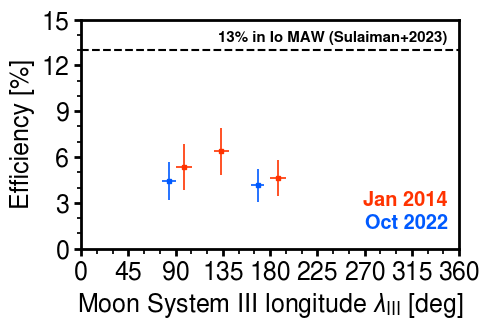

In [81]:
# KAPPA = 3
fontsize = 18
fig, ax = plt.subplots(figsize=(5.5, 3.4), dpi=100)
ax.set_zorder(1)
ax.patch.set_visible(False)  # prevents ax1 from hiding ax2
fig.tight_layout()
# ax.set_title('FUV Power (70-180 nm)', fontsize=fontsize, weight='bold')
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 6.1)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 7, 1))
# ax.set_yticklabels(np.arange(0, 23, 5), fontsize=fontsize)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'UV emission $P_{\rm UV}$ [GW]', fontsize=fontsize)
ax.text(0.01, 1.020, r'70-180 nm in North (KAPPA = 1)',
        color='k',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=fontsize*0.42)
ax.text(0.035, 0.93, 'STIS/SrF2',
        weight='bold',
        color='k',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.70, 0.93, '2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.85, 0.93, '2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)


# Emission
for i in range(len(doy)):
        ax.errorbar(moon_leadback_ave[i], EP_70180[i]*1E-9,
                xerr=moon_leadback_std[i], yerr=EP_std[i]*1E-9,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
    

# Poynting flux
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_ylim(0, 225)
ax2.set_yticks(np.arange(0, 225, 50))
# ax2.set_yticklabels(np.arange(0, 101, 25), fontsize=fontsize)
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax2.set_ylabel(r'Poynting flux $S_{\rm N}$ [GW]', fontsize=fontsize)


# JAN 2014 and OCT 2022
rho = [1207, 1708]      # [amu cm-3]
Ti = [87, 195]          # [eV]

S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)

for i in range(2):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        ax2.plot(np.degrees(S3wlon), 0.5*S*1E-9, color=cud4_N3[i])

# ERROR SHADES
pwr_14_arr = np.zeros((12, S3wlon.size))
for i in range(12):
        rho1, H = RHO_H(rho=rho14_arr[i], Ti=Ti14_arr[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho14_arr[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9
        pwr_14_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_14_arr.max(axis=0),
                 y2=pwr_14_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[0],
                 edgecolor=None,
                 zorder=0.6,)

pwr_22_arr = np.zeros((12, S3wlon.size))
for i in range(12):
        rho1, H = RHO_H(rho=rho22_arr[i], Ti=Ti22_arr[i], rvec1=rvec1)
        Sig_P = ((rho1/(rho22_arr[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9
        pwr_22_arr[i, :] = S
ax2.fill_between(x=np.degrees(S3wlon),
                 y1=pwr_22_arr.max(axis=0),
                 y2=pwr_22_arr.min(axis=0),
                 alpha=0.6,
                 color=cud4bs[3],
                 edgecolor=None,
                 zorder=0.6,)

fig.tight_layout()
plt.show()


# EFFICIENCY
S3wlon = np.radians(moon_leadback_ave)      # [rad]
B, rvec1 = Calc1(S3wlon)
rho = [1207, 1207, 1207, 1708, 1708]      # [amu cm-3]
Ti = [87, 87, 87, 195, 195]          # [eV]

fig, ax = plt.subplots(figsize=(5., 3.4), dpi=100)
fig.tight_layout()
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 10)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 16, 3))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'Efficiency [%]', fontsize=fontsize)

S_case2 = np.zeros(S3wlon.size)

for i in range(S3wlon.size):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1[:,i])
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B[i]**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B[i]*np.sqrt(rho1/MU0)
        ax.errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S))*100,
                xerr=moon_leadback_std[i], yerr=(EP_std[i]/(0.5*S))*100,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
        print('Efficiency: ', (EP_70180[i]/(0.5*S))*100, '%')
        S_case2[i] = S

ax.axhline(y=13, linestyle='dashed', color='k')
# ax.axhspan(4, 10, color='gray', alpha=0.1)
ax.text(0.97, 0.95, '13% in Io MAW (Sulaiman+2023)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)
"""ax.text(0.97, 0.64, '4-10% (Io)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)"""
ax.text(0.97, 0.25, 'Jan 2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.97, 0.15, 'Oct 2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
fig.tight_layout()

plt.show()

# Case 1 (0.8) & Case 2 (0.55)

Average S [GW]: 166.84562986583327
Average S [GW]: 160.62894818386792
Average S [GW]: 136.61637730191495
Average S [GW]: 177.03339403704163
Average S [GW]: 192.4273295341876
Error S [GW]: 49.98331293915586
Error S [GW]: 48.91975581257267
Error S [GW]: 44.51348122307163
Error S [GW]: 59.732730587613226
Error S [GW]: 62.815843580050725


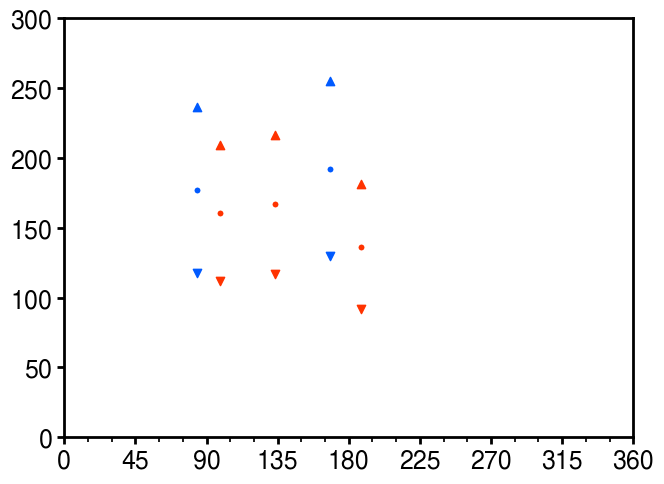

In [82]:
fig, ax = plt.subplots()
fig.tight_layout()
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 300)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks

# Determine the errors
for i in range(S3wlon.size):
        ax.scatter(moon_leadback_ave[i], S_case1[i]*1E-9, marker='^', c=cud4_N2[i])
for i in range(S3wlon.size):
        ax.scatter(moon_leadback_ave[i], S_case2[i]*1E-9, marker='v', c=cud4_N2[i])
for i in range(S3wlon.size):
        ax.scatter(moon_leadback_ave[i], 0.5*(S_case1[i]+S_case2[i])*1E-9, marker='.', c=cud4_N2[i])
        print('Average S [GW]:', 0.5*(S_case1[i]+S_case2[i])*1E-9)
for i in range(S3wlon.size):
        ax.scatter(moon_leadback_ave[i], 0.5*(S_case1[i]+S_case2[i])*1E-9, marker='.', c=cud4_N2[i])
        print('Error S [GW]:', (S_case1[i]-0.5*(S_case1[i]+S_case2[i]))*1E-9)

S_average = 0.5*(S_case1+S_case2)       # [W]
S_err = S_case1-0.5*(S_case1+S_case2)   # [W]

Efficiency:  4.456826720362734 %
Efficiency:  3.719991141054514 %
Efficiency:  3.1190476779774814 %
Efficiency:  2.928267354184207 %
Efficiency:  2.7989260606123216 %


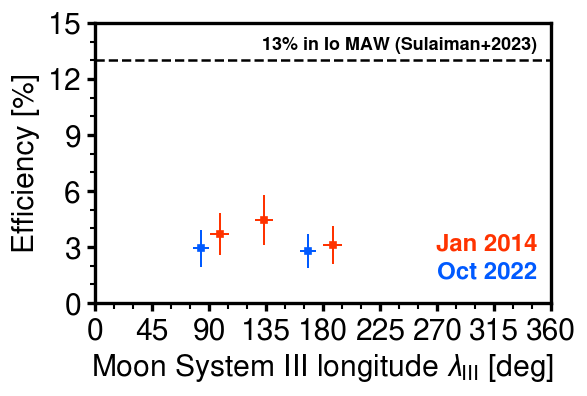

In [83]:
# EFFICIENCY
S3wlon = np.radians(moon_leadback_ave)      # [rad]
B, rvec1 = Calc1(S3wlon)
rho = [1207, 1207, 1207, 1708, 1708]      # [amu cm-3]
Ti = [87, 87, 87, 195, 195]          # [eV]

fig, ax = plt.subplots(figsize=(5., 3.4), dpi=120)
fig.tight_layout()
ax.tick_params(axis='both', labelsize=fontsize)
ax.yaxis.set_major_formatter(
    ptick.ScalarFormatter(useMathText=True))    # 指数表記
ax.set_xlim(0, 360)
ax.set_ylim(0, 10)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0, 16, 3))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_xlabel(
    r'Moon System III longitude $\lambda_{\rm III}$ [deg]', fontsize=fontsize)
ax.set_ylabel(r'Efficiency [%]', fontsize=fontsize)


for i in range(S3wlon.size):
        S = S_average[i]
        ax.errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S))*100,
                xerr=moon_leadback_std[i], yerr=(S_err[i]/S_average[i])*(EP_70180[i]/(0.5*S))*100,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
        print('Efficiency: ', (EP_70180[i]/(0.5*S))*100, '%')


ax.axhline(y=13, linestyle='dashed', color='k')
# ax.axhspan(4, 10, color='gray', alpha=0.1)
ax.text(0.97, 0.95, '13% in Io MAW (Sulaiman+2023)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)
"""ax.text(0.97, 0.64, '4-10% (Io)',
        weight='bold',
        color='k',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.6)"""
ax.text(0.97, 0.25, 'Jan 2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
ax.text(0.97, 0.15, 'Oct 2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=fontsize*0.8)
fig.tight_layout()

plt.show()

# PLOT FOR FIGURE 3

Case 1 [GW]: 108.41447140249456
Case 2 [GW]: 58.43115846333871
Case 1 [GW]: 104.7743519982203
Case 2 [GW]: 55.85459618564765
Case 1 [GW]: 90.5649292624933
Case 2 [GW]: 46.051448039421665
Case 1 [GW]: 118.38306231232743
Case 2 [GW]: 58.65033172471419
Case 1 [GW]: 127.62158655711916
Case 2 [GW]: 64.80574297706845


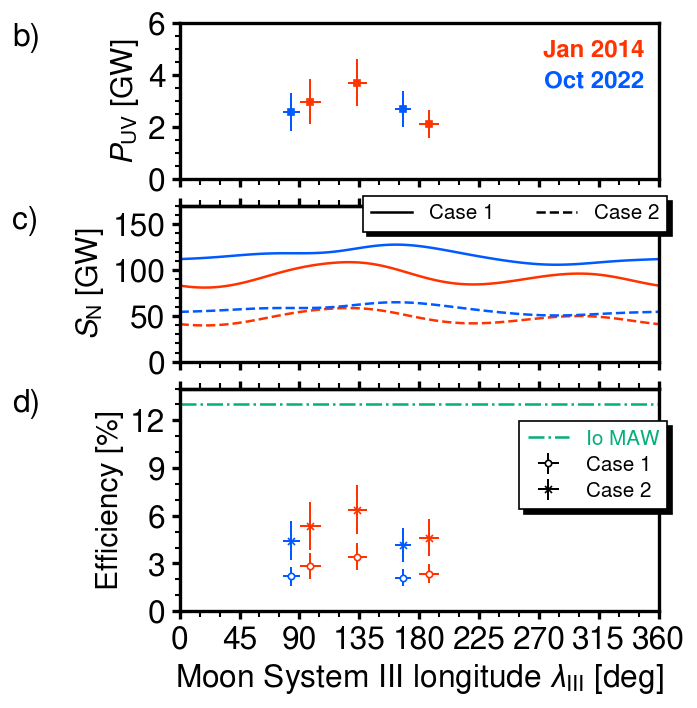

In [85]:
fsize = 19
fig, ax = plt.subplots(3, 1, figsize=(4.7, 5.5), dpi=120,
                       height_ratios=[0.7, 0.7, 1])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)
panelname = ['b','c','d','e','f','g','h']

for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)
ax[i].set_xlabel('Moon System III longitude $\\lambda_{\\rm III}$ [deg]', fontsize=fsize)


# PANEL B (EMISSION)
ax[0].set_ylim(0, 6)
ax[0].set_yticks(np.arange(0, 7, 2))
# ax.set_yticklabels(np.arange(0, 23, 5), fontsize=fontsize)
ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))  # minor ticks
ax[0].set_ylabel(r'$P_{\rm UV}$ [GW]', fontsize=fontsize)
for i in range(len(doy)):
        ax[0].errorbar(moon_leadback_ave[i], EP_70180[i]*1E-9,
                xerr=moon_leadback_std[i], yerr=EP_std[i]*1E-9,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)


# PANEL C (POYNTING FLUXES)
ax[1].set_ylim(0,170)
ax[1].set_yticks(np.arange(0, 151, 50))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[1].set_ylabel(r'$S_{\rm N}$ [GW]', fontsize=fontsize)
rho = [1207, 1708]      # [amu cm-3]
Ti = [87, 195]          # [eV]
kappa = 1       # Saur+2013
S3wlon = np.radians(np.linspace(0, 360, 100))      # [rad]
B, rvec1 = Calc1(S3wlon)
for i in range(2):
        rho1, H = RHO_H(rho=rho[i], Ti=Ti[i], rvec1=rvec1)

        # CASE 1
        Sig_P0 = 30     # Pedersen conductance [S]
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9   # [GW]
        S_case1a = S
        ax[1].plot(np.degrees(S3wlon), S_case1a, linestyle='-', color=cud4_N3[i])

        # CASE 2
        Sig_P0 = 10     # Pedersen conductance [S]
        Sig_P = ((rho1/(rho[i]*AMU*1E+6))**kappa)*Sig_P0
        Sig_A = np.sqrt(rho1/(MU0*(B**2)))  # Alfven conductance [S]
        alpha_bar = Sig_P/(Sig_P+2*Sig_A)
        S = 2*3.141592*(R_eff**2)*((alpha_bar*u)**2)*B*np.sqrt(rho1/MU0)
        S *= 0.5*1E-9   # [GW]
        S_case2a = S
        ax[1].plot(np.degrees(S3wlon), S_case2a, linestyle='--', color=cud4_N3[i])

        S_ave_model = 0.5*(S_case1a+S_case2a)       # [W]
        S_err_model = S_case1a-0.5*(S_case1a+S_case2a)   # [W]
        hatch = ['', '\\\\\\\\\\\\']
        # ax[1].plot(np.degrees(S3wlon), S_ave_model, color=cud4_N3[i])
        """ax[1].fill_between(x=np.degrees(S3wlon),
                 y1=S_ave_model+S_err_model,
                 y2=S_ave_model-S_err_model,
                 alpha=0.5-0.1*i,
                 hatch=hatch[i],
                 color=cud4bs[3*i],
                 edgecolor=None,
                 zorder=0.5,)"""
ax[1].plot(np.degrees(S3wlon), S_case1a+500, linestyle='-', 
           color='k', label='Case 1')
ax[1].plot(np.degrees(S3wlon), S_case1a+500, linestyle='--', 
           color='k', label='Case 2')



# PANEL D (EFFICIENCY)
ax[2].set_ylim(0,14)
ax[2].set_yticks(np.arange(0, 15, 3))
ax[2].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[2].set_ylabel(r'Efficiency [%]', fontsize=fontsize)
for i in range(S_average.size):
        S = S_average[i]
        """ax[2].errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S))*100,
                xerr=moon_leadback_std[i], yerr=(S_err[i]/S_average[i] + EP_std[i]/EP_70180[i])*(EP_70180[i]/(0.5*S))*100,
                marker='s', markersize=3.5, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)"""
        ax[2].errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S_case1[i]))*100,
                xerr=moon_leadback_std[i], yerr=(EP_std[i]/EP_70180[i])*(EP_70180[i]/(0.5*S_case1[i]))*100,
                marker='o', markersize=3.8, 
                mfc='w',
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
        print('Case 1 [GW]:', 0.5*S_case1[i]*1E-9)
        ax[2].errorbar(moon_leadback_ave[i], (EP_70180[i]/(0.5*S_case2[i]))*100,
                xerr=moon_leadback_std[i], yerr=(EP_std[i]/EP_70180[i])*(EP_70180[i]/(0.5*S_case2[i]))*100,
                marker='x', markersize=4.2, 
                mfc=cud4_N2[i],
                mec=cud4_N2[i], 
                linestyle='none', 
                ecolor=cud4_N2[i],
                elinewidth=1.2, zorder=1.5)
        print('Case 2 [GW]:', 0.5*S_case2[i]*1E-9)
        
# DUMMY
ax[2].errorbar(500, 500,
                xerr=500, yerr=1,
                marker='o', markersize=3.8, 
                mfc='w',
                mec='k', 
                linestyle='none', 
                ecolor='k',
                label='Case 1',
                elinewidth=1.2, zorder=1.5)
ax[2].errorbar(500, 500,
                xerr=500, yerr=1,
                marker='x', markersize=4.2, 
                mfc='k',
                mec='k', 
                linestyle='none', 
                ecolor='k',
                label='Case 2',
                elinewidth=1.2, zorder=1.5)

# IO MAW (SULAIMAN+2023)
ax[2].axhline(y=13, linestyle='-.', color=cud4[2], label="Io MAW")

ax[0].text(0.97, 0.90, 'Jan 2014',
        weight='bold',
        color=cud4[0],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax[0].transAxes,
        fontsize=fontsize*0.8)
ax[0].text(0.97, 0.70, 'Oct 2022',
        weight='bold',
        color=cud4[3],
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax[0].transAxes,
        fontsize=fontsize*0.8)


# =====================
# LEGEND FOR PANEL C
# =====================
legend1 = ax[1].legend(loc='upper right',
                       ncol=2,
                    bbox_to_anchor=(1.04, 1.13),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.69,
                    labelspacing=0.34,)
# legend1.set_title('Bagenal+ 2015', prop={'size': fontsize*0.6, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend1, dx=0.008, dy=-0.0073)


# =====================
# LEGEND FOR PANEL D
# =====================
legend2 = ax[2].legend(loc='upper right',
                    bbox_to_anchor=(1.04, 0.9),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.69,
                    labelspacing=0.34,)
# legend1.set_title('Bagenal+ 2015', prop={'size': fontsize*0.6, 'weight': 'bold'})
legend_shadow(fig, ax[2], legend2, dx=0.008, dy=-0.0073)

# get plot colors
i = 0
txtcolor = [cud4[2], 'k', 'k']
for legtext in legend2.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1